In [139]:
from nldg.utils import *
from nldg.smoothing_splines import *
from nldg.ss_utils import *

In [140]:
data_setting = 2
if data_setting == 1:
    dtr = gen_data_v2(n=1000)
elif data_setting == 2:
    dtr = gen_data_v3(n=1000, setting=2)
elif data_setting == 3:
    dtr = gen_data_v4(n_easy=1000, n_hard=1000)
elif data_setting == 4:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
else:
    dtr = gen_data_v6(n=1000, noise_std=0.5)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])

In [141]:
g_erm, g_erm_sorted, cs_erm = erm_ss(Xtr, Ytr, 1)
x_grid = np.linspace(min(Xtr), max(Xtr), 200)
preds_erm = cs_erm(x_grid)

In [ ]:
g_maximin, g_maximin_sorted, cs_maximin, p_maximin = minmax_ss(Xtr, Ytr, Etr, 1, method='gdro',
                                                               lr_g=0.01, eta=0.01, verbose=True, epochs=1000)
preds_maximin = cs_maximin(x_grid)

In [133]:
g_maximin, g_maximin_sorted, cs_maximin = minmax_ss(Xtr, Ytr, Etr, 1, method='extragradient',
                                                    alpha=0.15, verbose=True, epochs=10)
preds_maximin = cs_maximin(x_grid)

-1904528152921298.8 1908011272042339.2
tensor([0.4586, 0.5414, 0.0000]) tensor([24.5958, 25.1480, 11.6283])
tensor([0.4586, 0.5414, 0.0000]) tensor([24.5958, 25.1480, 11.6283])
Iter 0/10: obj=inf
tensor([0., 0., 0.]) tensor([1.6112e+16, 6.7358e+15, 4.9578e+20])
tensor([0., 0., 0.]) tensor([1.6112e+16, 6.7358e+15, 4.9578e+20])
Iter 1/10: obj=nan
tensor([nan, nan, nan]) tensor([inf, inf, inf])
tensor([nan, nan, nan]) tensor([inf, inf, inf])
Iter 2/10: obj=nan
tensor([nan, nan, nan]) tensor([nan, nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan, nan])
Iter 3/10: obj=nan
tensor([nan, nan, nan]) tensor([nan, nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan, nan])
Iter 4/10: obj=nan
tensor([nan, nan, nan]) tensor([nan, nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan, nan])
Iter 5/10: obj=nan
tensor([nan, nan, nan]) tensor([nan, nan, nan])
tensor([nan, nan, nan]) tensor([nan, nan, nan])
Iter 6/10: obj=nan
tensor([nan, nan, nan]) tensor([nan, nan, nan])
tensor([nan, nan, nan]) tensor

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

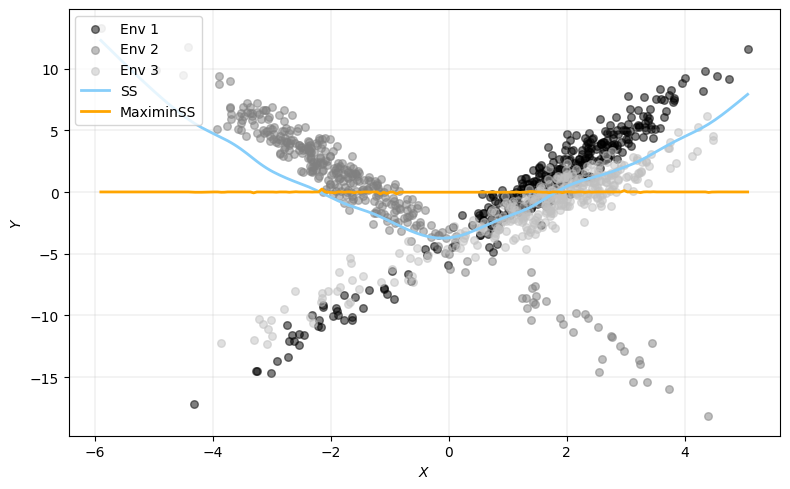

In [143]:
plot_dtr(dtr, x_grid, preds_erm, preds_maximin)

In [103]:
max_mse(Ytr, g_maximin, Etr, verbose=True)

Environment 0 MSE: 35.4108854917685
Environment 1 MSE: 80.94432796763353


np.float64(80.94432796763353)

In [127]:
def project_onto_simplex(v: torch.Tensor) -> torch.Tensor:
    """
    Euclidean projection of a vector v onto the probability simplex {p: p>=0, sum(p)=1}.
    Implementation based on sorting method, with safe-handling when all entries are very small.
    """
    u, _ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u, dim=0)
    # find rho: largest j where u_j * (j+1) > cssv_j - 1
    j = torch.arange(1, len(u) + 1, device=v.device)
    mask = u * j > (cssv - 1)
    idx = torch.where(mask)[0]
    if idx.numel() > 0:
        rho = idx.max()
    else:
        rho = torch.tensor(0, device=v.device)
    theta = (cssv[rho] - 1) / (rho.float() + 1.0)
    w = torch.clamp(v - theta, min=0)
    return w


def train_spline_extragradient(
    Y: np.ndarray,
    E: np.ndarray,
    K: np.ndarray,
    alpha: float = 1e-3,
    lam: float = 0.01,
    epochs: int = 500,
    seed: int = 0,
    verbose: bool = False,
):
    """
    Extragradient method for min_g max_p L(g,p) where
      L(g,p) = sum_e p_e * MSE_e(g) + lam * g^T K g,
    with p on the probability simplex.

    Inputs:
      Y: target vector of length n
      E: environment labels array length n
      K: Gram matrix (n x n)
    Returns:
      g: spline coefficients (n,)
      p: environment weights (num_env,)
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Setup
    envs, inv = np.unique(E, return_inverse=True)
    num_env = len(envs)
    n = len(Y)

    Y_t = torch.tensor(Y, dtype=torch.float32)
    inv_t = torch.tensor(inv, dtype=torch.long)
    K_t = torch.tensor(K, dtype=torch.float32)

    # initialize primal and dual
    g = torch.zeros(n, dtype=torch.float32)
    p = torch.ones(num_env, dtype=torch.float32) / num_env

    def compute_losses_and_grad(g_vec: torch.Tensor, p_vec: torch.Tensor):
        losses = []
        grad = torch.zeros_like(g_vec)
        for e in range(num_env):
            idx = torch.where(inv_t == e)[0]
            if idx.numel() == 0:
                losses.append(torch.tensor(0.0))
                continue
            y_e = Y_t[idx]
            pred_e = g[idx]
            loss_e = F.mse_loss(pred_e, y_e, reduction='mean')
            losses.append(loss_e)
            # gradient w.r.t g: (2/n_e) * (pred_e - y_e)
            resid = (pred_e - y_e)
            grad_e = (2.0 / idx.numel()) * resid
            grad.index_add_(0, idx, p_vec[e] * grad_e)
            #grad += p_vec[e] * grad_e
        losses = torch.stack(losses)
        # add reg grad
        grad += 2 * lam * (K_t @ g_vec)
        return losses, grad

    # extragradient loop
    for t in range(epochs):
        # step 1: compute at current (g, p)
        losses, grad = compute_losses_and_grad(g, p)
        g_half = g - alpha * grad
        p_half = project_onto_simplex(p + alpha * losses)

        # step 2: compute at (g_half, p_half)
        losses_h, grad_h = compute_losses_and_grad(g_half, p_half)
        g = g - alpha * grad_h
        p = project_onto_simplex(p + alpha * losses_h)

        print(p_half, losses)
        print(p, losses_h)

        if verbose and (t % max(1, epochs // 10) == 0):
            obj = (p * losses).sum() + lam * (g @ (K_t @ g))
            print(f"Iter {t}/{epochs}: obj={obj.item():.6f}")

    return g.detach().cpu().numpy(), p.detach().cpu().numpy()

In [132]:
def minmax_ss(X, Y, E, lam, method="cp", **kwargs):
    X = np.atleast_1d(X).flatten()
    idx = np.argsort(X)
    X, Y, E = X[idx], Y[idx], E[idx]
    n = len(X)

    h = np.diff(X)

    Q = np.zeros((n-2, n))
    for i in range(n-2):
        hi, hip1 = h[i], h[i+1]
        Q[i, i] =  1.0 / hi
        Q[i, i+1] = -1.0/hi - 1.0/hip1
        Q[i, i+2] =  1.0 / hip1

    R = np.zeros((n-2, n-2))
    for i in range(n-2):
        R[i, i] = (h[i] + h[i+1]) / 3.0
    for i in range(n-3):
        R[i, i+1] = h[i+1] / 6.0
        R[i+1, i] = h[i+1] / 6.0

    M = np.linalg.solve(R, Q)
    K = Q.T @ M

    if method == "cp":
        g = cp.Variable(n)
        t = cp.Variable(nonneg=True)

        constraints = []
        for env in np.unique(E):
            mask = (E == env)
            constraints.append(
                cp.sum_squares(Y[mask] - g[mask]) / np.sum(mask) <= t
            )

        smooth_pen = lam * cp.sum_squares(K @ g)
        obj = cp.Minimize(t + smooth_pen)

        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.SCS)

        g_sorted = g.value
        g_unsorted = np.empty_like(g_sorted)
        g_unsorted[idx] = g_sorted
        cs = CubicSpline(X, g_sorted, bc_type="natural")
        return g_unsorted, g_sorted, cs
    elif method == "gdro":
        g_sorted, p = train_spline_GDRO(Y, E, K, lam=lam, **kwargs)
        g_unsorted = np.empty_like(g_sorted)
        g_unsorted[idx] = g_sorted
        cs = CubicSpline(X, g_sorted, bc_type="natural")
        return g_unsorted, g_sorted, cs, p
    elif method == "extragradient":
        g_sorted = train_spline_extragradient(Y, E, K, lam=lam, **kwargs)
        g_unsorted = np.empty_like(g_sorted)
        g_unsorted[idx] = g_sorted
        cs = CubicSpline(X, g_sorted, bc_type="natural")
        return g_unsorted, g_sorted, cs
    else:
        g_sorted = train_spline_subgradient(Y, E, K, lam=lam, **kwargs)
        g_unsorted = np.empty_like(g_sorted)
        g_unsorted[idx] = g_sorted
        cs = CubicSpline(X, g_sorted, bc_type="natural")
        return g_unsorted, g_sorted, cs


def train_spline_GDRO(
    Y,
    E,
    K,
    lr_g=1e-3,
    eta=0.1,
    lam=0.01,
    epochs=500,
    weight_decay=0.0,
    early_stopping=True,
    patience=10,
    min_delta=1e-6,
    verbose=False,
    seed=0,
):
    torch.manual_seed(seed)

    envs, inv = np.unique(E, return_inverse=True)
    num_env = len(envs)
    n = len(Y)

    Y_t = torch.tensor(Y, dtype=torch.float32)
    inv_t = torch.tensor(inv, dtype=torch.long)
    K_t = torch.tensor(K, dtype=torch.float32)

    g = torch.tensor(g_erm_sorted, dtype=torch.float32, requires_grad=True)
    # g = torch.zeros(n, requires_grad=True)
    optimizer = optim.Adam([g], lr=lr_g, weight_decay=weight_decay)

    p = torch.ones(num_env, dtype=torch.float32) / num_env

    best_obj = float('inf')
    best_g = None
    best_p = None
    no_improve = 0

    for epoch in range(1, epochs + 1):
        print('.......................................')
        losses = []
        # Compute losses for each environment
        for i, env in enumerate(envs):
            mask = (inv_t == i)
            if mask.sum() == 0:
                losses.append(torch.tensor(0.0))
            else:
                pred = g[mask]
                true = Y_t[mask]
                losses.append(F.mse_loss(pred, true, reduction='mean'))
        losses = torch.stack(losses)

        print(losses)

        # Mirror ascent for p
        with torch.no_grad():
            p = p * torch.exp(eta * losses)
            p = p / p.sum()

        print('p', p)
        # Compute weighted loss and regularizer
        weighted_loss = torch.dot(p, losses)
        print('weighted loss', weighted_loss)
        reg = lam * (g @ (K_t @ g))
        print('reg', reg)
        obj = weighted_loss + reg

        # Gradient descent step on g
        optimizer.zero_grad()
        obj.backward()
        optimizer.step()

        current = obj.item()
        print(current, best_obj)
        # Early stopping / track best
        if current + min_delta < best_obj:
            best_obj = current
            best_g = g.detach().cpu().numpy().copy()
            best_p = p.detach().cpu().numpy().copy()
            no_improve = 0
        else:
            no_improve += 1

        if verbose and epoch % max(1, epochs // 10) == 0:
            print(f"Epoch {epoch}: obj={current:.6f}, best={best_obj:.6f}")
        if early_stopping and no_improve >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break

    # Fallback if no improvement ever
    if best_g is None:
        best_g = g.detach().cpu().numpy()
        best_p = p.detach().cpu().numpy()

    return best_g, best_p

In [89]:
def train_spline_online_GDRO(
    Y: np.ndarray,
    E: np.ndarray,
    K: np.ndarray,
    lr_g: float = 1e-3,
    eta: float = 0.1,
    lam: float = 0.01,
    epochs: int = 10000,
    batch_size: int = 1,
    seed: int = 0,
    early_stopping: bool = True,
    patience: int = 10,
    min_delta: float = 1e-6,
    device: torch.device = torch.device("cpu"),
    verbose: bool = False,
):
    """
    Online GDRO for spline coefficients g and environment weights p.
    Inputs:
      Y: target vector (n,)
      E: environment labels (n,)
      K: kernel Gram matrix (n,n)
    Returns:
      best_g: learned spline coefficients (n,)
      best_p: environment weights (num_env,)
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    # Prepare data
    envs, inv = np.unique(E, return_inverse=True)
    num_env = len(envs)
    n = len(Y)

    # Tensors
    Y_t = torch.tensor(Y, dtype=torch.float32, device=device)
    inv_t = torch.tensor(inv, dtype=torch.long, device=device)
    K_t = torch.tensor(K, dtype=torch.float32, device=device)

    # Initialize g, p
    g = torch.tensor(g_erm_sorted, dtype=torch.float32, device=device, requires_grad=True)
    #g = torch.zeros(n, dtype=torch.float32, device=device, requires_grad=True)
    p = torch.ones(num_env, dtype=torch.float32, device=device) / num_env

    optimizer = optim.Adam([g], lr=lr_g)

    # Precompute indices by environment
    idx_by_env = {i: torch.where(inv_t == i)[0] for i in range(num_env)}

    best_obj = float('inf')
    best_g = None
    best_p = None
    no_improve = 0

    for t in range(1, epochs + 1):
        # Sample environment g_idx
        g_idx = np.random.randint(num_env)
        idxs = idx_by_env[g_idx]
        # Sample batch of indices
        if batch_size < len(idxs):
            batch_idxs = idxs[torch.from_numpy(
                np.random.choice(len(idxs), batch_size, replace=False)
            )]
        else:
            batch_idxs = idxs

        # Batch targets and predictions
        y_batch = Y_t[batch_idxs]
        g_batch = g[batch_idxs]
        # Loss for this env
        loss_env = F.mse_loss(g_batch, y_batch, reduction='mean')

        # Mirror ascent on p[g_idx]
        with torch.no_grad():
            p[g_idx] = p[g_idx] * torch.exp(eta * loss_env)
            p /= p.sum()

        # Composite objective: weighted loss + regularizer
        reg = lam * (g @ (K_t @ g))
        obj = p[g_idx] * loss_env + reg

        # Gradient step
        optimizer.zero_grad()
        obj.backward()
        optimizer.step()

        current_obj = obj.item()
        # Track best
        if current_obj + min_delta < best_obj:
            best_obj = current_obj
            best_g = g.detach().cpu().clone().numpy()
            best_p = p.detach().cpu().clone().numpy()
            no_improve = 0
        else:
            no_improve += 1

        # Verbose logging
        if verbose and t % max(1, epochs // 10) == 0:
            worst = torch.argmax(p).item()
            print(f"Iter {t}/{epochs}: env={g_idx}, loss={loss_env.item():.4f}, obj={current_obj:.4f}, worst_env={worst}")

        # Early stopping
        if early_stopping and no_improve >= patience:
            if verbose:
                print(f"Early stopping at iter {t}")
            break

    # Fallback
    if best_g is None:
        best_g = g.detach().cpu().numpy()
        best_p = p.detach().cpu().numpy()

    return best_g, best_p

In [64]:
def train_spline_subgradient(
    Y,
    E,
    K,
    lr=1e-2,
    lam=1e-3,
    epochs=500,
    verbose=False,
):
    #evals = np.linalg.eigvalsh(K)
    #K = K / evals.max()

    envs = np.unique(E)
    num_env = len(envs)
    n = len(Y)

    g = np.zeros(n)

    for epoch in range(1, epochs + 1):
        # 1) compute per‐env MSE
        losses = np.zeros(num_env)
        for e in range(num_env):
            mask = (E == e)
            if np.sum(mask) == 0:
                losses[e] = 0.0
            else:
                pred = g[mask]
                true = Y[mask]
                losses[e] = np.mean((pred-true)**2)

        # 2) pick worst‐case environment
        e_star = int(losses.argmax().item())
        f_star = losses[e_star].item()

        print(f_star)

        # 3) compute subgradient of f_{e*}
        mask = E == e_star
        Y_e = Y[mask]
        g_e = g[mask]
        n_e = np.sum(mask)

        # ∇_β MSE = (2/n_e) N_eᵀ (N_e β − y_e)
        grad_data = np.zeros(n)
        grad_data[mask] = (2.0 / n_e) * (g_e - Y_e)

        # ∇_β reg = 2 λ K g
        grad_reg = 2 * lam * (K @ g)

        gk = grad_data + grad_reg

        # 4) subgradient descent update
        g = g - lr * gk

        if verbose and (epoch % (epochs // 10 or 1) == 0):
            obj = f_star + lam * (g @ (K @ g)).item()
            print(
                f"iter {epoch:4d}  env={e_star}  MSE={f_star:.4e}  obj={obj:.4e}"
            )

    return g